In [1]:
import json
import string
import random
import nltk
import numpy as np
import keras

In [2]:
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [3]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Processing Data

In [4]:
lm = WordNetLemmatizer()

ourClasses = []
newWords = []
documentX = []
documentY = []

f = open('/content/FAQs_8.json')
data = json.load(f)

for i in data['intents']:
    for pattern in i["patterns"]:
        ournewTKns = nltk.word_tokenize(pattern)
        newWords.extend(ournewTKns)
        documentX.append(pattern)
        documentY.append(i["tag"])

    if i ["tag"] not in ourClasses:
        ourClasses.append(i["tag"])

newWords = [lm.lemmatize(word.lower()) for word in newWords if word not in string.punctuation]
newWords = sorted(set(newWords))
ourClasses = sorted(set(ourClasses))

In [5]:
len(newWords)

345

Designing Neural Network Model

In [6]:
trainingData = []
outEmpty = [0] * len(ourClasses)

for idx, doc in enumerate(documentX):
    bag_of_words = []
    text = lm.lemmatize(doc.lower())
    for word in newWords:
        bag_of_words.append(1) if word in text else bag_of_words.append(0)

    outputRow = list(outEmpty)
    outputRow[ourClasses.index(documentY[idx])] = 1
    trainingData.append([bag_of_words, outputRow])

random.shuffle(trainingData)
trainingData = np.array(trainingData, dtype=object)

x = np.array(list(trainingData[:, 0]))
y = np.array(list(trainingData[:, 1]))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(documentX, documentY, test_size=0.2, random_state=42)

In [8]:
ishape = (len(newWords),)
oshape = (len(y[0]))

ourNewModel = Sequential()

ourNewModel.add(Dense(280, input_shape=ishape, activation="relu"))
ourNewModel.add(Dropout(0.5))

ourNewModel.add(Dense(140, activation="relu"))
ourNewModel.add(Dropout(0.3))

ourNewModel.add(Dense(70, activation="relu"))
ourNewModel.add(Dropout(0.3))

ourNewModel.add(Dense(oshape, activation="softmax"))

md = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-6)

ourNewModel.compile(loss='categorical_crossentropy', optimizer=md, metrics=["accuracy"])
print(ourNewModel.summary())
ourNewModel.fit(x, y, epochs=900, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 280)               96880     
                                                                 
 dropout (Dropout)           (None, 280)               0         
                                                                 
 dense_1 (Dense)             (None, 140)               39340     
                                                                 
 dropout_1 (Dropout)         (None, 140)               0         
                                                                 
 dense_2 (Dense)             (None, 70)                9870      
                                                                 
 dropout_2 (Dropout)         (None, 70)                0         
                                                                 
 dense_3 (Dense)             (None, 59)                4

In [9]:
ourNewModel.save('path_to_save_model')

In [10]:
model_json = ourNewModel.to_json()
with open('path_to_save_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save the learned weights to a file
ourNewModel.save_weights('path_to_save_model_weights.h5')

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

# Assuming you have a separate JSON file for test data
testX = []
testY = []

with open('/content/FAQs_8.json') as f:
    test_data = json.load(f)

for item in test_data['intents']:
    for pattern in item["patterns"]:
        testX.append(pattern)
        testY.append(item["tag"])

# Preprocess test data similarly to training data
testWords = [lm.lemmatize(word.lower()) for word in testX if word not in string.punctuation]
testWords = sorted(set(testWords))

# Create a CountVectorizer using the vocabulary from the training data
vectorizer = CountVectorizer(vocabulary=newWords)

# Transform the test data to bag-of-words representation
X_test_bow = vectorizer.transform(testX)
X_test_bow_dense = X_test_bow.toarray()

# Make predictions on the test set
predictions_test = ourNewModel.predict(X_test_bow_dense)

# Convert predictions to labels
predicted_labels_test = [ourClasses[np.argmax(pred)] for pred in predictions_test]

# Calculate test accuracy
accuracy_test = accuracy_score(testY, predicted_labels_test)
print("Test Accuracy:", accuracy_test)


12/12 [==============================] - 0s 3ms/step
Test Accuracy: 0.8722826086956522


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Calculate precision, recall, and f1 score
precision_test = precision_score(testY, predicted_labels_test, average='weighted', zero_division=1)
recall_test = recall_score(testY, predicted_labels_test, average='weighted', zero_division=1)
f1_test = f1_score(testY, predicted_labels_test, average='weighted', zero_division=1)

# Print the results
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)

Precision: 0.9200044665558825
Recall: 0.8722826086956522
F1 Score: 0.8749330994070322


In [13]:
class_report = classification_report(testY, predicted_labels_test, zero_division=1)
print("\nClassification Report:\n", class_report)


Classification Report:
                                                   precision    recall  f1-score   support

Can a transfer student be still be a TES grantee       1.00      1.00      1.00         3
         How do I know If I got delisted for TES       1.00      1.00      1.00         3
                                             TES       0.67      0.67      0.67         3
                       TES application available       0.90      0.64      0.75        14
        TES application open for all year levels       0.75      1.00      0.86         3
                               admission_process       1.00      1.00      1.00        41
                    admission_process_continuing       1.00      1.00      1.00         7
                       admission_process_default       1.00      0.50      0.67         2
                           admission_process_new       0.62      1.00      0.76         8
                                             age       1.00      1.00     

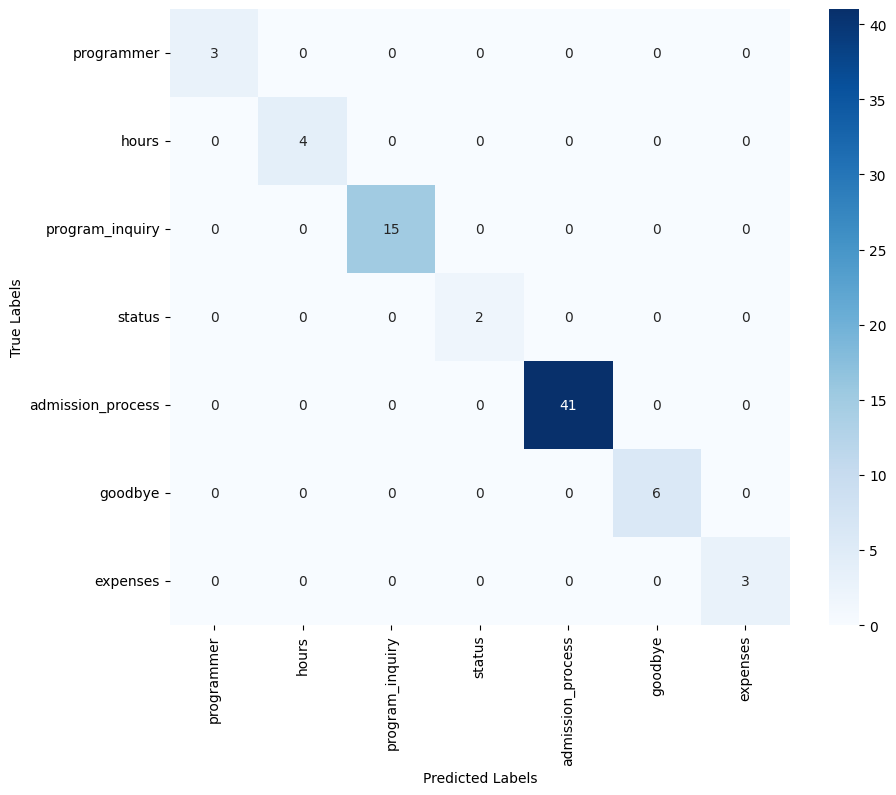

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
selected_classes = ["programmer", "hours", "program_inquiry", "status", "admission_process", "goodbye", "expenses"]

# Get indices of selected classes in the true_labels and predicted_labels
selected_indices = [i for i, label in enumerate(testY) if label in selected_classes]
selected_true_labels = [testY[i] for i in selected_indices]
selected_predicted_labels = [predicted_labels_test[i] for i in selected_indices]

# Calculate confusion matrix for selected classes
conf_matrix_selected = confusion_matrix(selected_true_labels, selected_predicted_labels, labels=selected_classes)

# Plot the confusion matrix for selected classes
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_selected, annot=True, fmt='d', cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Building Features

In [16]:
def ourText(text):
    newtkns = nltk.word_tokenize(text)
    newtkns = [lm.lemmatize(word) for word in newtkns]
    return newtkns

def wordBag(text, vocab):
    newtkns = ourText(text)
    bag_of_words = np.zeros(len(vocab))
    for w in newtkns:
        indices = np.where(np.array(vocab) == w)[0]
        bag_of_words[indices] = 1
    return bag_of_words

def Pclass(text, vocab, labels):
    bag_of_words = wordBag(text, vocab)
    ourResult = ourNewModel.predict(np.array([bag_of_words]))[0]
    newThresh = 0.95
    yp = [[idx, res] for idx, res in enumerate(ourResult) if res > newThresh]

    if not yp:
      return["noanswer"]

    yp.sort(key = lambda x: x[1], reverse = True)
    newList = []
    for r in yp:
        newList.append(labels[r[0]])


    return newList

def getRes(intents, json_data):
    if "admission_process" in intents:
        return handleAdmissionProcess(intents, json_data)
    elif "program inquiry" in intents:
        return handleProgramInquiry(intents, json_data)
    elif len(intents) == 0:
        tag = 'noanswer'
    else:
        tag = intents[0]

    list_of_intents = json_data["intents"]

    for i in list_of_intents:
        if i["tag"] == tag:
            our_result = random.choice(i["responses"])
            break
    return our_result

def handleProgramInquiry(intents, json_data):
    if "graduate" in intents:
        response_tag = "graduate_programs"
    elif "undergraduate" in intents:
        response_tag = "undergraduate_programs"

def handleAdmissionProcess(intents, json_data):
    # Check if the user specified whether they are a continuing or new student
    if "continuing" in intents:
        response_tag = "admission_process_continuing"
    elif "new" in intents:
        response_tag = "admission_process_new"
    else:
        response_tag = "admission_process_default"

    # Get the response for the specified admission process scenario
    list_of_intents = json_data["intents"]
    for i in list_of_intents:
        if i["tag"] == response_tag:
            our_result = random.choice(i["responses"])
            break

    return our_result

In [17]:
similarities = []
print("Hello! I'm your chatbot assistant. I answer frequently asked questions for Admission and Scholarship Office.")
print("Here are some of the FAQs you can ask:")
print("- Tell me about the admission process.")
print("- Are there any scholarship offers?")
print("- Can you provide information about the courses offered?")
while True:
    user_input = input("User: ")
    newMessage = user_input.lower()
    intents = Pclass(newMessage, newWords, ourClasses)
    ourResult = getRes(intents, data)
    print("ChatBot:",ourResult)
    if "goodbye" in intents:
        break

Hello! I'm your chatbot assistant. I answer frequently asked questions for Admission and Scholarship Office.
Here are some of the FAQs you can ask:
- Tell me about the admission process.
- Are there any scholarship offers?
- Can you provide information about the courses offered?
User: Hello
1/1 [==============================] - 0s 103ms/step
ChatBot: Hello, how can I help?
User: list of scholarships
1/1 [==============================] - 0s 21ms/step
ChatBot: Sorry, can't understand you
User: list of scholarships in lasalle
1/1 [==============================] - 0s 21ms/step
ChatBot: Not sure I understand you
User: list of available scholarships
1/1 [==============================] - 0s 23ms/step
ChatBot: 
 We have three scholarships that are available:
 Br.Benildo Feliciano FSC Scholarship 
 -For incoming Senior High School graduates who make it to the TOP 10 of a school's graduating class with at least 50 graduates 
 Br.Arnold Reche FSC Scholarship 
 -Given to financially challenged